Author: Kelley Monzella <br>
Date: 11/14/2021<br>
Subject: EDA for final project

In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
from   scipy             import stats
import pyspark.sql.functions as f
from pyspark.sql.functions   import rank, col,approxCountDistinct, countDistinct

#change configuration settings on Spark 
spark = SparkSession.builder.appName('SparkBasics').getOrCreate()

conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '200g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '8'), ('spark.cores.max', '8'), ('spark.driver.memory','30g')])

#print spark configuration settings
sc   = spark.sparkContext
spark

In [5]:
#%time df = spark.read.format("org.apache.spark.csv").option("multiline", "true").csv("/user/kmonzella/data/youtube_clean.csv", inferSchema=True, header=True, quote='\"', sep = ",", escape='"')
df = spark.read.json("/user/kmonzella/data/youtube_clean.json")

In [6]:
df.show(2)

+-----+--------------+-------------+--------------------+--------------------+-------------+------------+--------------+---------+----------+--------+-----------------+------+--------+----------+-----------------+------------------+----------+----------------+---------+--------------------+--------------------+--------------------+--------+---------+----------+--------------------+
|  _c0|age_restricted|       author|             channel|         description|duration_long|duration_med|duration_short|has_music|has_sounds|keywords|language_detected|length|metadata|n_keywords|n_posts_by_author|n_posts_by_channel|post_covid|publish_date_new|   rating|         stream_info|               title|          transcript|   views|views_cat|views_high|           watch_url|
+-----+--------------+-------------+--------------------+--------------------+-------------+------------+--------------+---------+----------+--------+-----------------+------+--------+----------+-----------------+-----------------

In [7]:
# test write out file
#test = df.limit(2)
#test.coalesce(1).write.mode('overwrite').option('header','true').csv('/user/kmonzella/data/test.csv')
# hdfs dfs -copyToLocal /user/kmonzella/data/test.csv ~/data/


# A. Overview: Basic summary statistics on dataset

In [8]:
# check number of rows and values

print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print(f'There are total {df.count()} row, Lets print first 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):
There are total 376741 row, Lets print first 2 data rows:


,_c0,age_restricted,author,channel,description,duration_long,duration_med,duration_short,has_music,has_sounds,...,post_covid,publish_date_new,rating,stream_info,title,transcript,views,views_cat,views_high,watch_url
0,81613,False,Kent Survival,UC-HFqs_7nzHwg1pD-_PrLcw,Exploring a new Pine forest in the Truck and s...,0,1,0,0.0,1.0,...,1,2021-05-05,4.884477,"[<Stream: itag=""17"" mime_type=""video/3gpp"" res...",Solo Roof-Top Tent Truck Overnighter - Camping...,[Music] do [Music] so hello again as you can s...,609393.0,3,1,https://youtube.com/watch?v=RITrE_84PI4
1,45890,False,Sparkfly88,UC-JNyVxECc9J0QlKkHI4Zaw,Trying to figure out if I'm missing any compon...,0,0,1,0.0,0.0,...,1,2021-10-22,5.000000,"[<Stream: itag=""17"" mime_type=""video/3gpp"" res...",2000 yamaha 25hp 2 stroke timing linkage,None,6.0,1,0,https://youtube.com/watch?v=bcfWGlOdSek


In [9]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,_c0,bigint
1,age_restricted,boolean
2,author,string
3,channel,string
4,description,string
5,duration_long,bigint
6,duration_med,bigint
7,duration_short,bigint
8,has_music,double
9,has_sounds,double


# B. Univariates

## 1. Outcome variable - views

In [10]:
# check min, max, median, and average values for references

df.agg(f.min(col("views")), f.max(col("views")), f.avg(col("views"))).show()
print(df.approxQuantile("views", [0.5], 0.25))

+----------+-------------+-----------------+
|min(views)|   max(views)|       avg(views)|
+----------+-------------+-----------------+
|       0.0|7.606261432E9|2938226.109276955|
+----------+-------------+-----------------+

[2161157210.0]


In [11]:
# how many observations have zero views or less than 100 views

n_zero = df.filter("views == 0").count() 
print(n_zero)

n_lt100 = df.filter("views < 100").count() 
print(n_lt100)

percent_lt100 = n_lt100 * 100 / df.count()
print(percent_lt100)


3499
77941
20.6882181657956


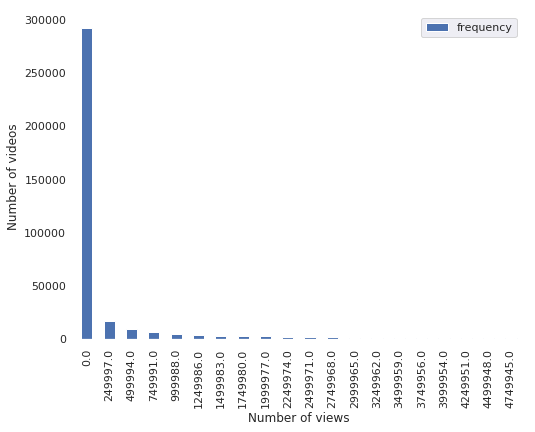

In [31]:
# given high outliers, which we will show later, limit the data to obs with < 5000000 views

view_histogram = df.filter("views < 5000000").select('views').rdd.flatMap(lambda x: x).histogram(20)

# Loading the Computed Histogram into a Pandas Dataframe for plotting

def print_hist(inputview):
    pd.DataFrame(
        list(zip(*inputview)), 
        columns=['bin', 'frequency']).round(0).set_index('bin').plot(kind='bar').set(xlabel='Number of views', ylabel='Number of videos', facecolor = "w")

print_hist(view_histogram)


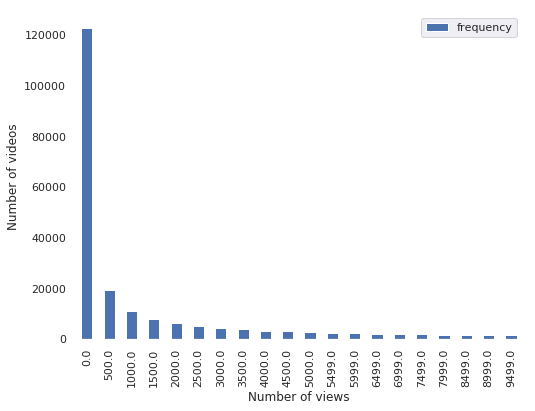

In [32]:
# to see some of the variation in earlier bins, further limit view max

view_histogram_small = df.filter("views < 10000").select('views').rdd.flatMap(lambda x: x).histogram(20)
print_hist(view_histogram_small)

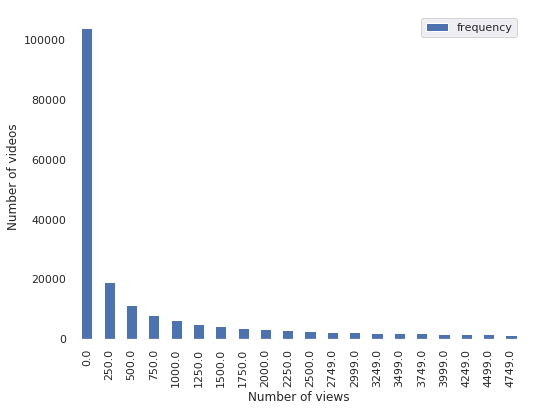

In [33]:
# to see some of the variation in earlier bins, further limit view max

view_histogram_small = df.filter("views < 5000").select('views').rdd.flatMap(lambda x: x).histogram(20)
print_hist(view_histogram_small)

In [16]:
# check the categorical and binary version

df.groupBy("views_high").count().show()
df.groupBy("views_cat").count().show()

+----------+------+
|views_high| count|
+----------+------+
|         0|205418|
|         1|171323|
+----------+------+

+---------+------+
|views_cat| count|
+---------+------+
|        1|141889|
|        3|171323|
|        2| 63529|
+---------+------+



+------------------------------------------+
|percentile(views, CAST(0.95 AS DOUBLE), 1)|
+------------------------------------------+
|                         6160814.899999999|
+------------------------------------------+

6160814.899999999


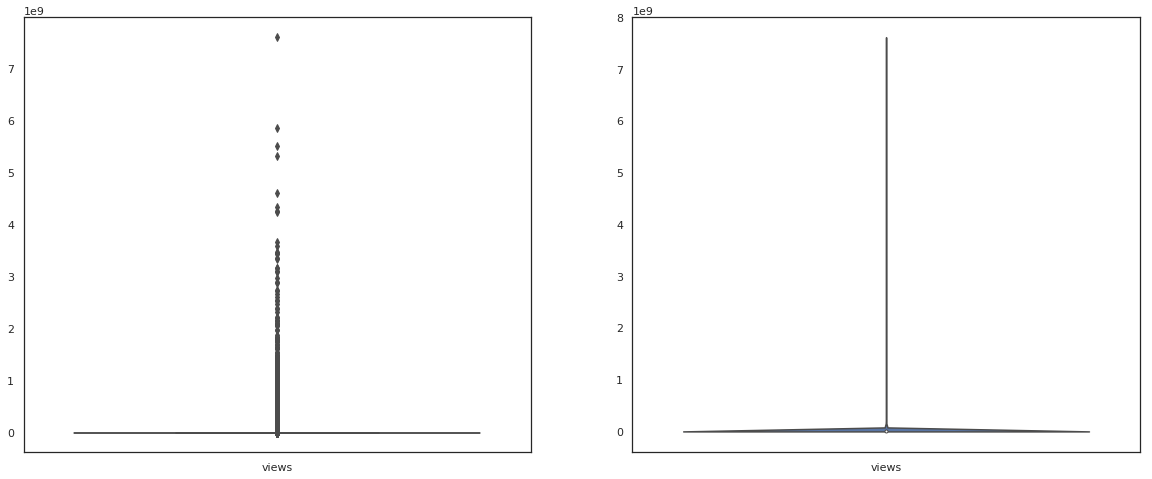

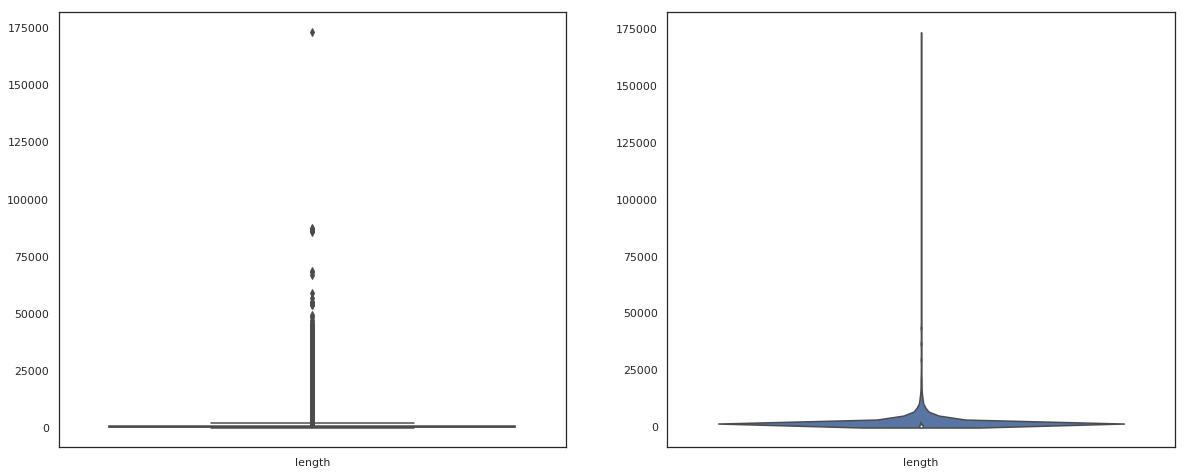

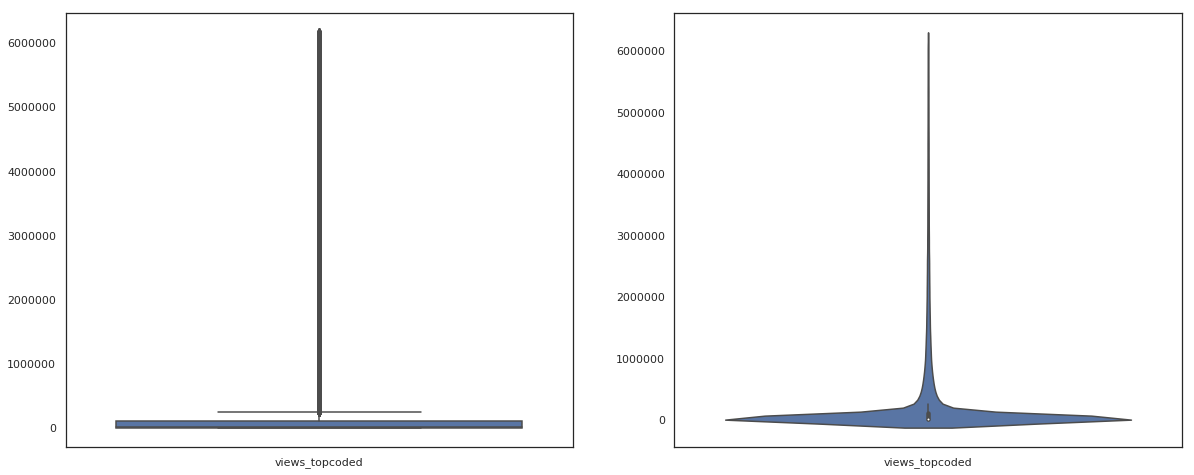

In [35]:
# plot views, original and top coded
sns.set(style="white")
df.selectExpr('percentile(views, 0.95)').show()
p = df.selectExpr('percentile(views, 0.95)').collect()[0][0]

print(p)
df = df.withColumn("views_topcoded", f.when(col("views") > p, None).otherwise(col("views")))


varlist = ["views", "length", "views_topcoded"]

for var in varlist:
    x = df.select(var).toPandas()
    
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 2, 1)
    ax = sns.boxplot(data=x)
    
    ax = fig.add_subplot(1, 2, 2)
    ax = sns.violinplot(data=x)

## 2. Duration

+-----------+-----------+------------------+
|min(length)|max(length)|       avg(length)|
+-----------+-----------+------------------+
|        1.0|   172801.0|1049.1442135159527|
+-----------+-----------+------------------+

[66766.0]


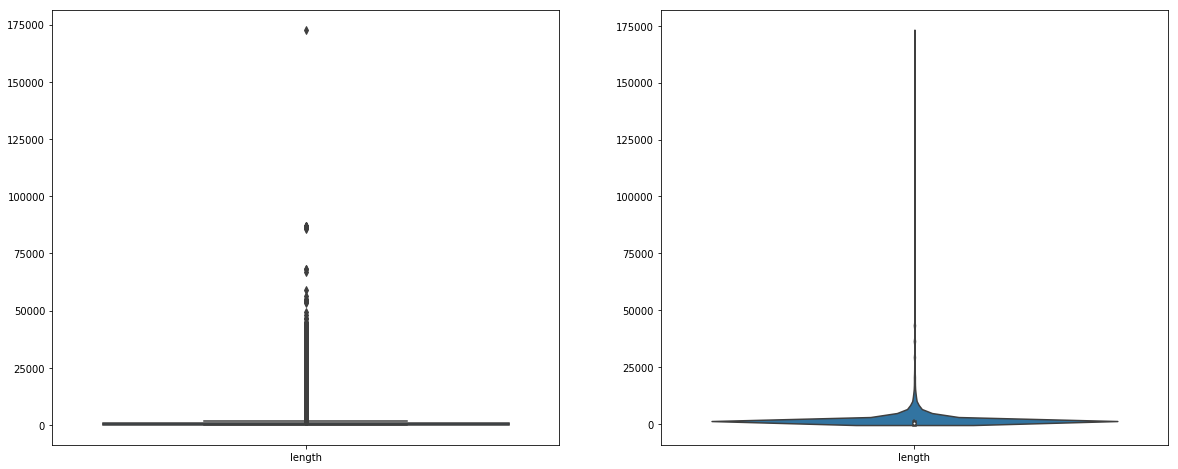

In [17]:
# check the minimum, maximum, and median values of duration (length)

df.agg(f.min(col("length")), f.max(f.col("length")), f.avg(col("length"))).show()
print(df.approxQuantile("length", [0.5], 0.25))

# plot for reference

varlist = ["length"]

for var in varlist:
    x = df.select(var).toPandas()
    
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 2, 1)
    ax = sns.boxplot(data=x)

    ax = fig.add_subplot(1, 2, 2)
    ax = sns.violinplot(data=x)

## 3. Date variables

In [18]:
# check earliest and latest dates

df.agg(f.min(f.col("publish_date_new")),  f.max(f.col("publish_date_new"))).show()


+---------------------+---------------------+
|min(publish_date_new)|max(publish_date_new)|
+---------------------+---------------------+
|           2005-04-23|           2021-11-20|
+---------------------+---------------------+



In [19]:
# create month and year variables to help with summaries

from pyspark.sql.functions import month, year

df = df.withColumn('month', month(df.publish_date_new))
df = df.withColumn('year',  year(df.publish_date_new))
df.select(["publish_date_new", "year", "month"]).show()


+----------------+----+-----+
|publish_date_new|year|month|
+----------------+----+-----+
|      2021-05-05|2021|    5|
|      2021-10-22|2021|   10|
|      2019-08-08|2019|    8|
|      2021-04-24|2021|    4|
|      2019-05-08|2019|    5|
|      2017-09-01|2017|    9|
|      2021-10-23|2021|   10|
|      2021-10-24|2021|   10|
|      2015-03-31|2015|    3|
|      2018-11-16|2018|   11|
|      2016-10-18|2016|   10|
|      2021-06-28|2021|    6|
|      2019-03-18|2019|    3|
|      2021-03-17|2021|    3|
|      2021-03-17|2021|    3|
|      2021-03-17|2021|    3|
|      2021-08-10|2021|    8|
|      2021-08-09|2021|    8|
|      2016-08-08|2016|    8|
|      2021-03-31|2021|    3|
+----------------+----+-----+
only showing top 20 rows



In [20]:
df.groupBy("year", "month").count().show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|2007|    6|   87|
|2012|   10|  688|
|2010|   12|  386|
|2010|    7|  286|
|2015|    2| 1006|
|2019|   10| 3245|
|2017|    3| 1589|
|2008|    8|  154|
|2017|    8| 1687|
|2014|    4|  796|
|2009|   11|  328|
|2020|    6| 5604|
|2005|   10|    1|
|2019|    5| 2642|
|2018|   10| 2369|
|2017|   10| 1900|
|2021|    8|12339|
|2015|   12|  922|
|2016|    7| 1176|
|2021|    6|10876|
+----+-----+-----+
only showing top 20 rows



In [21]:
# how many years in data?

df.select(approxCountDistinct("year", rsd = 0.01)).show()

+---------------------------+
|approx_count_distinct(year)|
+---------------------------+
|                         17|
+---------------------------+



## 4. Languages

In [22]:
# check how many languages are in dataset

df.select(approxCountDistinct("language_detected",  rsd = 0.01)).show()

# print the languages, by which are most popular - count and percentage of total

tot = df.count()

summ_df = df.groupBy("language_detected") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_group') \
  .withColumn('perc_of_count_total', (f.col('cnt_per_group') / tot) * 100 ) \

summ_df.show()

# only keep top 5 for plot
summ_df.sort("count", ascending=False).show(15)
summ_df = summ_df.sort("count", ascending=False).limit(5).toPandas()

+----------------------------------------+
|approx_count_distinct(language_detected)|
+----------------------------------------+
|                                      55|
+----------------------------------------+

+-----------------+-------------+--------------------+
|language_detected|cnt_per_group| perc_of_count_total|
+-----------------+-------------+--------------------+
|               en|       289878|   76.94357662160476|
|               vi|         2312|  0.6136842021441786|
|               ne|           62|0.016456929296253926|
|               ro|         2579|  0.6845551718554657|
|               sl|          771| 0.20464987882922223|
|               ur|           33|0.008759333335102894|
|               lv|          130| 0.03450646465343565|
|               pl|          811| 0.21526725256874085|
|               sk|          361| 0.09582179799915591|
|          unknown|          430| 0.11413676769982561|
|               pt|         3996|  1.0606756365779144|
|             

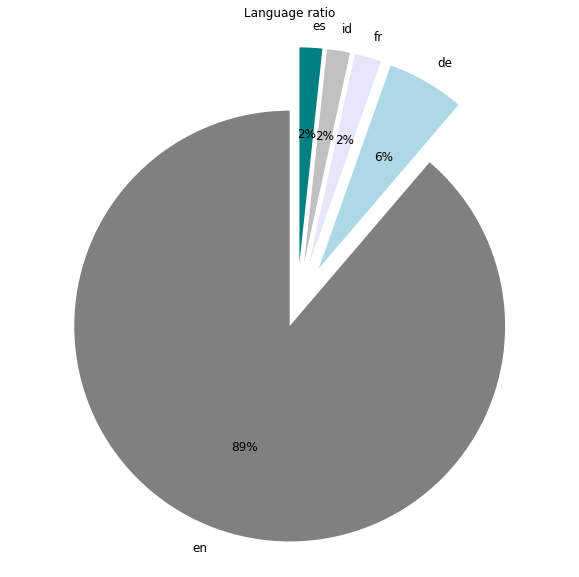

In [23]:
# print as a pie chart

fig, ax1 = plt.subplots(figsize=(10,10))
title1   = ax1.set_title('Language ratio')
explode  = (0.1, .2, .2, .2, .2)  

ax1.pie(summ_df['perc_of_count_total'], \
        explode=explode, \
        labels=summ_df['language_detected'], \
        autopct='%1.0f%%',\
        colors = ['gray', 'lightblue', 'lavender', 'silver', 'teal'],\
        shadow=False, startangle=90, textprops={'fontsize': 12})
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


## 6. Authors

In [24]:
df.select(approxCountDistinct("author", rsd = 0.01)).show()

+-----------------------------+
|approx_count_distinct(author)|
+-----------------------------+
|                       200401|
+-----------------------------+



# C. Multivariates

## 1. Scatter plots

import seaborn as sns
sns.set(style="ticks")

df2 = df.select("views_high", "rating").toPandas()
sns.pairplot(df2, hue="rating")
plt.show()

## 2a. Time plots - rating over time

In [26]:
# aggregate data to the month/year level to show trends over time

dfplot = df.filter("year > 2010").groupBy(["year", "month"]).agg(f.avg(col('views')), f.avg(col('rating')), f.count(col("watch_url")))

# sort the data for plotting 

dfplot.sort(["year", "month"]).show()
dfplot = dfplot.toPandas()

# create a combined Y/M measure

dfplot['date'] = dfplot['month'].map(str)+ '-' +dfplot['year'].map(str)
dfplot = dfplot.sort_values(['year','month'])


+----+-----+--------------------+------------------+----------------+
|year|month|          avg(views)|       avg(rating)|count(watch_url)|
+----+-----+--------------------+------------------+----------------+
|2011|    1|   5774067.073490813| 4.141876636745406|             381|
|2011|    2|   8187154.297709923| 4.225071542239187|             393|
|2011|    3|   7298229.641078838|  4.06774086099585|             482|
|2011|    4|   9491293.424623115| 3.919642359547739|             398|
|2011|    5|  5216971.7397540985|3.9908203627049184|             488|
|2011|    6|   7351581.875816993| 4.067079511111111|             459|
|2011|    7|   7145714.637209303| 4.133828774883722|             430|
|2011|    8|   5447922.596810934|3.9244365826879273|             439|
|2011|    9|   4981589.338329764|4.2428115586723765|             467|
|2011|   10|1.0181378764705881E7| 4.047111578373702|             578|
|2011|   11|   5121279.490272374| 4.140816204085602|             514|
|2011|   12|  249562

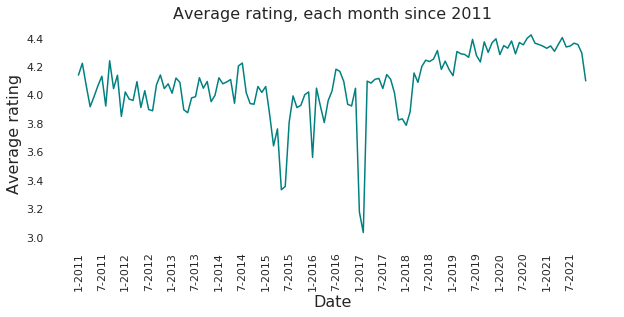

In [27]:
# plot ratings over time
%matplotlib inline

plt.rcParams['figure.figsize'] =(8,6)
plt.style.use('ggplot')
sns.set()

fig, ax1 = plt.subplots(figsize=(10,4))
ax1.set_title('Average rating, each month since 2011', fontsize=16)

ax1 = sns.lineplot(x='date', y='avg(rating)', data = dfplot, sort=False, color='teal')

ax1.set_xlabel('Date',          fontsize=16)
ax1.set_ylabel('Average rating', fontsize=16)
ax1.tick_params(axis='x',        rotation=90)

ax1.set_xticks(np.arange(0, len(dfplot['date'])+1, 6))
ax1.set_facecolor("w")
plt.show()

## 2b. Time plots - number of videos in data over time

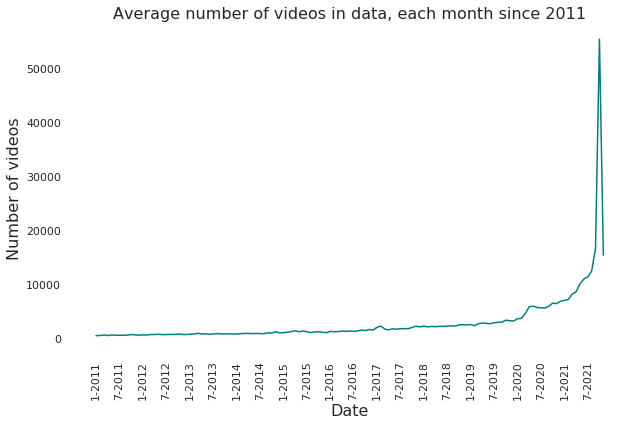

In [28]:
%matplotlib inline

plt.rcParams['figure.figsize'] =(6,4)
plt.style.use('ggplot')
sns.set()

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Average number of videos in data, each month since 2011', fontsize=16)

ax1 = sns.lineplot(x='date', y='count(watch_url)', data = dfplot, sort=False, color='teal')

ax1.set_xlabel('Date',          fontsize=16)
ax1.set_ylabel('Number of videos', fontsize=16)
ax1.tick_params(axis='x',        rotation=90)

ax1.set_xticks(np.arange(0, len(dfplot['date'])+1, 6))
ax1.set_facecolor("w")
plt.show()

## 2c. Time plots - average views over time

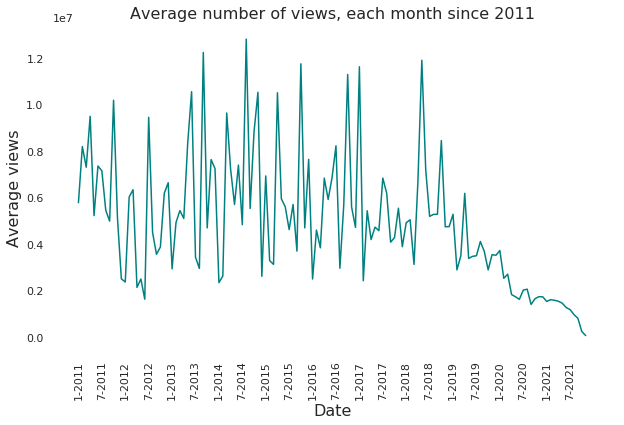

In [29]:

%matplotlib inline

plt.rcParams['figure.figsize'] =(8,6)
plt.style.use('ggplot')
sns.set()

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Average number of views, each month since 2011', fontsize=16)

ax1 = sns.lineplot(x='date', y='avg(views)', data = dfplot, sort=False, color='teal')

ax1.set_xlabel('Date',          fontsize=16)
ax1.set_ylabel('Average views', fontsize=16)
ax1.tick_params(axis='x',        rotation=90)

ax1.set_xticks(np.arange(0, len(dfplot['date'])+1, 6))
ax1.set_facecolor("w")
plt.show()

# D. Check examples for presentation

In [30]:
# most popular videos

df.select(["title", "views"]).sort(col("views").desc()).show(10, truncate = False)

+---------------------------------------------------------------------------------------+-------------+
|title                                                                                  |views        |
+---------------------------------------------------------------------------------------+-------------+
|Luis Fonsi - Despacito ft. Daddy Yankee                                                |7.606261432E9|
|Johny Johny Yes Papa ���� THE BEST Song for Children | LooLoo Kids                     |5.853802585E9|
|Ed Sheeran - Shape of You (Official Music Video)                                       |5.513711838E9|
|Wiz Khalifa - See You Again ft. Charlie Puth [Official Video] Furious 7 Soundtrack     |5.311180161E9|
|Bath Song | CoComelon Nursery Rhymes & Kids Songs                                      |4.598901945E9|
|Mark Ronson - Uptown Funk (Official Video) ft. Bruno Mars                              |4.345405818E9|
|Phonics Song with TWO Words - A For Apple - ABC Alphabet Songs 